## 概要
### 基本処理のみ
- 欠損値処理
- ラベルエンコード

In [212]:
import pandas as pd
import numpy as np
import json
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import re

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn
print('sklearn version:', sklearn.__version__)

import warnings
warnings.filterwarnings('ignore')

lightgbm version: 2.3.0
sklearn version: 0.22.1


In [213]:
train = pd.read_csv('input/train_data.csv')
test = pd.read_csv('input/test_data.csv')

In [214]:
# ↑のjsonファイルをnames.jsonで保存してある前提
with open("columns.json", "r", encoding="utf-8") as f:
     d = json.load(f)
        
train = train.rename(columns=d)
test = test.rename(columns=d)        

In [215]:
pub = pd.read_csv('./input/published_land_price.csv')

In [216]:
pair = {"所在地コード":"市区町村コード","建蔽率":"建ぺい率（％）","容積率":"容積率（％）","駅名":"最寄駅：名称", 
        "地積":"面積（㎡）","市区町村名":"市区町村名",'前面道路の幅員':'前面道路：幅員（ｍ）', 
        "前面道路の方位区分":"前面道路：方位","前面道路区分":"前面道路：種類","形状区分":"土地の形状",
        "用途区分":"都市計画"
         }

In [217]:
pub = pub.rename(columns=pair)

In [218]:
pub.rename(columns=d)

,id,経度,緯度,MunicipalityCode,Use,連番,年次,前年所在地コード,前年用途,前年連番,...,属性移動Ｈ２２,属性移動Ｈ２３,属性移動Ｈ２４,属性移動Ｈ２５,属性移動Ｈ２６,属性移動Ｈ２７,属性移動Ｈ２８,属性移動Ｈ２９,属性移動Ｈ３０,属性移動Ｈ３１
0,1,500891.116,123138.601,13364,0,1,2019,13364,0,1,...,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000
1,2,500894.320,123142.529,13364,5,1,2019,13364,5,1,...,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000
2,3,500912.888,123159.352,13364,0,2,2019,13364,0,2,...,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000
3,4,501125.227,128626.391,13228,0,15,2019,13228,0,15,...,10000100000000,10000000000000,10000000000000,20000000000000,20000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000
4,5,501133.658,128900.214,13205,0,23,2019,13205,0,23,...,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,2598,503670.276,128547.220,13123,0,71,2019,13123,0,71,...,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000
2598,2599,503692.697,128521.480,13123,0,66,2019,13123,0,66,...,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000
2599,2600,511887.899,97541.683,13421,0,1,2019,0,0,0,...,0,0,0,0,0,0,0,0,0,40000000000000
2600,2601,511898.328,97541.651,13421,5,1,2019,13421,5,1,...,10010000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000


## 不要なカラムを落とす 

In [219]:
delete_columns = ['id', 'Prefecture', 'Municipality', 'DistrictName']
train = train.drop(delete_columns, axis=1)
test = test.drop(delete_columns, axis=1)

In [220]:
 train = train.drop_duplicates()

In [221]:
y = train['y']
train = train.drop('y', axis=1)

In [222]:
data = pd.concat([train, test])

## 数値データの整形

In [223]:
def calc_mean_median(df, df_type):
    dumy = df
    dumy = dumy.dropna()
    dumy = dumy.astype(df_type)
    df = df.fillna(dumy.mean())
    df = df.astype(df_type)
    return df

### 最寄駅：距離（分） 

In [224]:
data['TimeToNearestStation'] = data['TimeToNearestStation'].replace('2H?', '120').replace('30分?60分', '45'). \
        replace('1H30?2H', '105').replace('1H?1H30', '75')

In [225]:
data['TimeToNearestStation'] = calc_mean_median(data['TimeToNearestStation'], np.int64)

### 面積

In [226]:
dumy_area = data['Area'].replace('2000㎡以上', np.nan).replace('5000㎡以上', np.nan)
dumy_area = dumy_area.dropna()
dumy_area = dumy_area.astype(np.int64)
# 2000以上5000以下の平均値を取得
area_mean_2000_5000 = np.mean([i for i in dumy_area if i > 2000 and i < 5000])
# 5000以上はないので5500で置換
# 欠損値を埋めるための平均と中央値
dim_mean = dumy_area.mean()
dim_median = dumy_area.median()

In [227]:
data['Area'] = data['Area'].replace('2000㎡以上',  area_mean_2000_5000).replace('5000㎡以上', 5500)
data['Area'] =  data['Area'].fillna(dim_mean)  
data['Area'] = data['Area'].astype(np.int64)

### 間口

In [228]:
data['Frontage'] = data['Frontage'].replace('50.0m以上', '60.0')

In [229]:
data['Frontage'] =   calc_mean_median(data['Frontage'], np.float32)

### 延床面積（㎡）

In [230]:
data['TotalFloorArea'] = data['TotalFloorArea'].replace('2000㎡以上', '2500').replace( '10m^2未満', '5')

In [231]:
data['TotalFloorArea'] =  calc_mean_median(data['TotalFloorArea'], np.int64)

### 築年数

In [232]:
tiku_columns = ['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '戦前', '平成29年', '昭和36年',
       '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年', '平成30年',
       '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年', '昭和33年',
       '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年', '昭和22年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年']

for i in tiku_columns:
    if '平成' in i:
        year = int(i.replace('年', '').replace('平成', '')) +2000-12
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
    if '昭和' in i:
        year = int(i.replace('年', '').replace('昭和', '')) + 1925
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
        

In [233]:
data['BuildingYear'].unique()

array([1984, 2003, 2012, 1986, 1999, 1985, 2007, 1998, nan, 1982, 1970,
       1972, 1968, 1989, 2013, 2004, 1997, 1993, 1976, 2001, 1977, 1980,
       1979, 1990, 2009, 2010, 2006, 2002, 1994, 2005, 1987, 2000, 1963,
       1966, 1973, 2008, 1978, 1974, 2014, 1983, 1981, 1960, 1975, 1962,
       2011, 1995, 1991, 1988, '戦前', 2017, 1961, 2016, 1964, 1992, 2015,
       1967, 1956, 2018, 1969, 1954, 1996, 1952, 1971, 1955, 1958, 1957,
       1965, 1951, 1959, 1950, 1953, 1947, 1949, 1948, 1946, 2019],
      dtype=object)

In [234]:
data['BuildingYear'] = data['BuildingYear'].replace('戦前', 1960)

In [235]:
data['BuildingYear'] =  calc_mean_median(data['BuildingYear'], np.int64)

## 前面道路：幅員（ｍ）

In [236]:
data['Breadth']=  calc_mean_median(data['Breadth'], np.float64)

###  建ぺい率（％) 容積率（％） 

In [237]:
data['CoverageRatio']=  calc_mean_median(data['CoverageRatio'], np.float64)
data['FloorAreaRatio']=  calc_mean_median(data['FloorAreaRatio'], np.float64)

### 取引時点

In [238]:
torihiki_columns = data['Period'].unique()

In [239]:
for i, value in enumerate(sorted(torihiki_columns)):
    data['Period'] =  data['Period'].replace(value, i)

## カテゴリーデータの整形

### 最寄駅：名称 - labelエンコード

### 間取り

In [240]:
data['L'] = data['FloorPlan'].map(lambda x: 1 if 'Ｌ' in str(x) else 0)
data['D'] = data['FloorPlan'].map(lambda x: 1 if 'Ｄ' in str(x) else 0)
data['K'] = data['FloorPlan'].map(lambda x: 1 if 'Ｋ' in str(x) else 0)
data['S'] = data['FloorPlan'].map(lambda x: 1 if 'Ｓ' in str(x) else 0)
data['R'] = data['FloorPlan'].map(lambda x: 1 if 'Ｒ' in str(x) else 0)
data['Maisonette'] = data['FloorPlan'].map(lambda x: 1 if 'メゾネット' in str(x) else 0)
data['OpenFloor'] = data['FloorPlan'].map(lambda x: 1 if 'オープンフロア' in str(x) else 0)
data['Studio'] = data['FloorPlan'].map(lambda x: 1 if 'スタジオ' in str(x) else 0)

## カウント数

In [241]:
def makeCountFull(data, categorical_features=None, report=True):
    add_cols = categorical_features
    if report:
        print('add_cols: ', add_cols)
    for add_col in add_cols:
        data[add_col + '_countall'] = data[add_col].map(data[add_col].value_counts(dropna=False))
    return data

In [242]:
categorical_features = ['Type', 'Region', 'NearestStation', 'FloorPlan','LandShape', 'Structure', 'Use', 'Purpose', 'Direction', \
         'Classification', 'CityPlanning', 'Renovation', 'Remarks']

In [243]:
for c in categorical_features:
    data[c] =  data[c].fillna('missing') 

In [244]:
from sklearn.preprocessing import LabelEncoder

for c in categorical_features:
    le = LabelEncoder()
    le.fit(data[c])
    data[c] = le.transform(data[c])

In [245]:
# data = makeCountFull(data, categorical_features)

In [246]:
# data = data.drop(categorical_features, axis=1)

In [247]:
data.dtypes

Type                      int64
Region                    int64
MunicipalityCode          int64
NearestStation            int64
TimeToNearestStation      int64
FloorPlan                 int64
Area                      int64
LandShape                 int64
Frontage                float32
TotalFloorArea            int64
BuildingYear              int64
Structure                 int64
Use                       int64
Purpose                   int64
Direction                 int64
Classification            int64
Breadth                 float64
CityPlanning              int64
CoverageRatio           float64
FloorAreaRatio          float64
Period                    int64
Renovation                int64
Remarks                   int64
L                         int64
D                         int64
K                         int64
S                         int64
R                         int64
Maisonette                int64
OpenFloor                 int64
Studio                    int64
dtype: o

In [248]:
data.head()

,Type,Region,MunicipalityCode,NearestStation,TimeToNearestStation,FloorPlan,Area,LandShape,Frontage,TotalFloorArea,...,Renovation,Remarks,L,D,K,S,R,Maisonette,OpenFloor,Studio
0,0,0,13101,628,1,23,55,0,9.702674,177,...,1,0,1,1,1,0,0,0,0,0
1,0,0,13101,628,5,6,20,0,9.702674,177,...,2,0,0,0,1,0,0,0,0,0
2,0,0,13101,628,3,11,45,0,9.702674,177,...,2,0,1,1,1,0,0,0,0,0
3,0,0,13101,628,5,14,20,0,9.702674,177,...,2,0,0,0,0,0,1,0,0,0
4,2,2,13101,628,3,0,80,1,6.800000,330,...,0,0,0,0,0,0,0,0,0,0


## 学習

In [249]:
train = data[:len(train)]

In [207]:
len(test)

34844

In [250]:
test = data[len(train):]

In [251]:
len(y)

352857

In [271]:
# y_pred = np.zeros(test.shape[0], dtype='float32')
# train_pred = np.zeros(X.shape[0], dtype='float32')

X_train, X_valid, y_train, y_valid = train_test_split(train, y, random_state=0)
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid)
params = {
    'objective': 'regression',
    'metric': 'mape',
    'learning_rate': 0.001,
    'max_depth': -1,
    'num_leaves': 255,
    'max_bin': 255,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
}
model = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                  num_boost_round=5000, early_stopping_rounds=200,
                  verbose_eval=200)

y_val_pred = model.predict(X_valid)
val_score = np.sqrt(mean_squared_error(y_valid, y_val_pred))
print('RMSE:', val_score)

Training until validation scores don't improve for 200 rounds
[200]	training's mape: 1.76276	valid_1's mape: 1.77621
[400]	training's mape: 1.51989	valid_1's mape: 1.53285
[600]	training's mape: 1.31959	valid_1's mape: 1.33226
[800]	training's mape: 1.15305	valid_1's mape: 1.16531
[1000]	training's mape: 1.01674	valid_1's mape: 1.02901
[1200]	training's mape: 0.904926	valid_1's mape: 0.917399
[1400]	training's mape: 0.811576	valid_1's mape: 0.824368
[1600]	training's mape: 0.734815	valid_1's mape: 0.747783
[1800]	training's mape: 0.671679	valid_1's mape: 0.684938
[2000]	training's mape: 0.619808	valid_1's mape: 0.63316
[2200]	training's mape: 0.577207	valid_1's mape: 0.591299
[2400]	training's mape: 0.541207	valid_1's mape: 0.555952
[2600]	training's mape: 0.511554	valid_1's mape: 0.526706
[2800]	training's mape: 0.48713	valid_1's mape: 0.50281
[3000]	training's mape: 0.466569	valid_1's mape: 0.482656
[3200]	training's mape: 0.449415	valid_1's mape: 0.465763
[3400]	training's mape: 0.4

In [272]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
feature_importances['importance'] = model.feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
2,MunicipalityCode,168285
6,Area,141032
20,Period,116477
3,NearestStation,102871
16,Breadth,100701
8,Frontage,95785
4,TimeToNearestStation,80696
10,BuildingYear,79397
19,FloorAreaRatio,71573
9,TotalFloorArea,70059


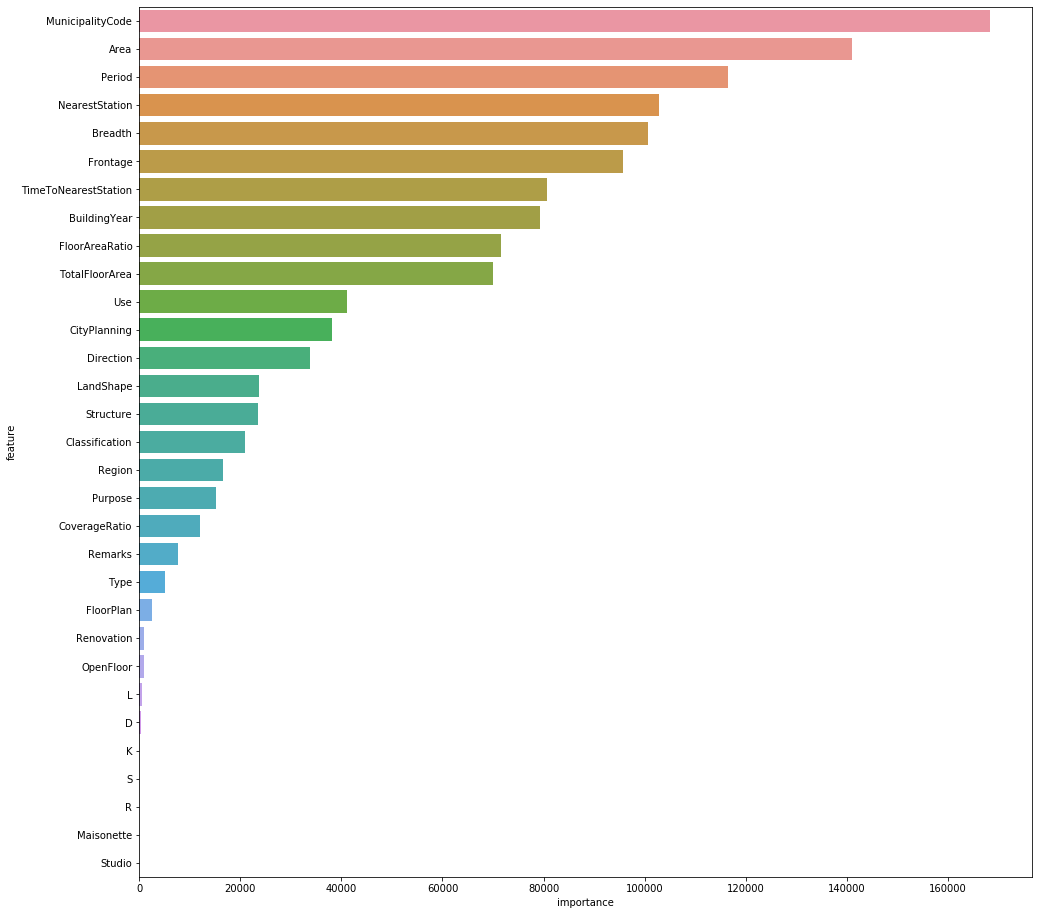

In [273]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(70), x='importance', y='feature')

In [274]:
y_pred  = model.predict(test, num_iteration=model.best_iteration)

In [275]:
y_pred = np.round(y_pred, 2)

In [276]:
y_pred

array([ 24.05,  14.17, 225.34, ...,   5.75,  13.2 ,   7.02])

In [277]:
submit = pd.read_csv('input/test_data.csv')

In [278]:
sub = pd.DataFrame({'id': submit['id'], 'y': y_pred})

In [279]:
sub.to_csv('sub_2_mape.csv', index=False)